In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce
from torch_scatter import scatter
from tqdm.autonotebook import tqdm
from icecream import ic
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

from utils.dataset import *
from utils.clustering import get_cluster_embeddings
from utils.entropy import compute_entropies

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
seed_everything(42)

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

module_activation_dict = {
    # Conv blocks
    'audio_encoder.base.conv_block1': nn.Identity(),    # 0
    'audio_encoder.base.conv_block2': nn.Identity(),    # 1
    'audio_encoder.base.conv_block3': nn.Identity(),    # 2
    'audio_encoder.base.conv_block4': nn.Identity(),    # 3
    'audio_encoder.base.conv_block5': nn.Identity(),    # 4
    'audio_encoder.base.conv_block6': nn.Identity(),    # 5
    # 'audio_encoder.base.fc1': F.relu,                   # 6
}

module_list = list(module_activation_dict.keys())

In [6]:
dataset = ESC50Dataset()

Using downloaded and verified file: /scratch/pratyaksh.g/esc50/ESC-50-master.zip


2000it [00:00, 11987.97it/s]

Loading audio files


In [7]:
class_indices = torch.tensor([dataset.class_to_idx[klass] for klass in dataset.class_label]).to(DEVICE)

## Neuron-level entropy distribution

In [86]:
seed_everything(42)

In [87]:
entropies = []
for layer_name in tqdm(module_list):
    root = '/scratch/pratyaksh.g/'
    layer_activations = torch.load(root + f'{dataset.path_name}/activations/{layer_name}.pt').to(DEVICE)
    layer_entropy = compute_entropies(layer_activations, class_indices, len(dataset.classes))
    entropies.append(layer_entropy)

  0%|          | 0/7 [00:00<?, ?it/s]

In [88]:
all_entropies = torch.cat([x.flatten() for x in entropies]).to('cpu').numpy()

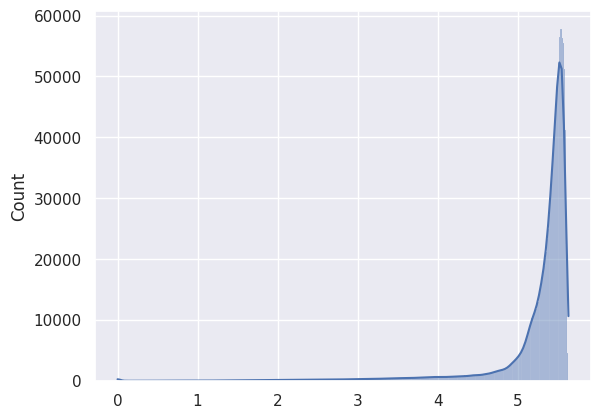

Mean: 5.260542392730713


AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

In [ ]:

sns.histplot(all_entropies, bins=500, kde=True)
plt.show()
print(f"Mean: {all_entropies.mean()}")
print(f"Median: {np.median(all_entropies)}")
print(f"Standard deviation: {all_entropies.std()}")

In [11]:
all_entropies.mean() - all_entropies.std()

4.6643066

## Findng optimal partitions

In [8]:
def calculate_distance(node1, node2):
    # Define your distance metric here
    # For example, you can calculate Euclidean distance or any other metric
    # This function should return the distance between node1 and node2
    # For simplicity, let's assume nodes are represented as tuples of coordinates
    return abs(node1 - node2) / max(node1, node2)

def find_min_weight_k_clique(partition_nodes, k):
    min_weight = float('inf')
    min_clique = None

    for clique in tqdm(itertools.product(*partition_nodes), mininterval=1):
        if len(set(clique)) < k:
            continue

        for combination in itertools.combinations(clique, k):
            weight = sum(calculate_distance(node1, node2) for node1, node2 in itertools.combinations(combination, 2))
            if weight < min_weight:
                min_weight = weight
                min_clique = combination

    return min_clique, min_weight

In [9]:
root = '/scratch/pratyaksh.g/'
esc_n_clusters = []
for layer_name in module_list:
    esc_n_clust = torch.load(root + f'/esc50/clusters/{layer_name}_n.pt')
    esc_n_clusters.append([x.item() for x in esc_n_clust])
esc_n_clusters

[[142626, 21326, 4903, 1102, 227, 27, 5],
 [82080, 15439, 2818, 656, 132, 19, 4],
 [43304, 7528, 1253, 267, 35, 4],
 [24544, 4832, 1235, 204, 15, 2],
 [10533, 2591, 921, 63, 12],
 [24284, 5862, 1721, 178, 38, 8],
 [211, 31, 4]]

In [10]:
partition_nodes = esc_n_clusters
k = len(esc_n_clusters)

min_clique, min_weight = find_min_weight_k_clique(partition_nodes, k)
print("Minimum weight k-clique:", min_clique)

0it [00:00, ?it/s]

Minimum weight k-clique: (227, 132, 267, 204, 63, 178, 211)


In [11]:
# In each partition, find the index needed for the min clique
esc_pt = []
for i, n_clusters in enumerate(esc_n_clusters):
    esc_pt.append(n_clusters.index(min_clique[i]))

## Cluster-level semantic entropy trends

In [85]:
seed_everything(42)

In [86]:
root = '/scratch/pratyaksh.g/'

In [87]:
for layer_name in module_list:
    n_clusters = torch.load(root + f'{dataset.path_name}/clusters/{layer_name}_n.pt')
    print(layer_name, n_clusters)

audio_encoder.base.conv_block1 tensor([142626,  21326,   4903,   1102,    227,     27,      5])
audio_encoder.base.conv_block2 tensor([82080, 15439,  2818,   656,   132,    19,     4])
audio_encoder.base.conv_block3 tensor([43304,  7528,  1253,   267,    35,     4])
audio_encoder.base.conv_block4 tensor([24544,  4832,  1235,   204,    15,     2])
audio_encoder.base.conv_block5 tensor([10533,  2591,   921,    63,    12])
audio_encoder.base.conv_block6 tensor([24284,  5862,  1721,   178,    38,     8])


In [88]:
ic(esc_pt)
ic(min_clique)

ic| esc_pt: [4, 4, 3,

 3, 3, 3, 0]
ic| min_clique: (227, 132, 267, 204, 63, 178, 211)


(227, 132, 267, 204, 63, 178, 211)

In [108]:
layerwise_entropies = []
for idx, layer_name in enumerate(module_list):
    activations = torch.load(root + f'{dataset.path_name}/activations/{layer_name}.pt')
    clusters = torch.load(root + f'{dataset.path_name}/clusters/{layer_name}.pt')
    n_clusters = torch.load(root + f'{dataset.path_name}/clusters/{layer_name}_n.pt')

    cluster_embeddings = get_cluster_embeddings(activations, clusters[:, esc_pt[idx]].unsqueeze(-1), n_clusters[esc_pt[idx]].unsqueeze(-1))
    embed = cluster_embeddings[0]
    act = rearrange(embed, 'clust inst -> inst clust').to(DEVICE)

    # # Compute entropies
    layer_entropy = compute_entropies(act, class_indices, len(dataset.classes))
    layerwise_entropies.append(layer_entropy)
layerwise_entropies = [x.cpu().numpy() for x in layerwise_entropies]

In [109]:
ic(len(layerwise_entropies))
ic([x.shape for x in layerwise_entropies])
None

ic| len(layerwise_entropies): 7
ic| [x.shape for x in layerwise_entropies]: [(227,), (132,), (267,), (204,), (63,), (178,), (211,)]


In [110]:
df = pd.DataFrame({
    'layer': sum([ [f'conv{i + 1}'] * len(x) for i, x in enumerate(layerwise_entropies)], start=[]),
    'entropy': np.concatenate(layerwise_entropies),
    'max entropy': np.log2(50)
})
df['entropy ratio'] = df['entropy'] / df['max entropy']

In [71]:
df

,layer,entropy,max entropy,entropy ratio
0,conv1,5.531674,5.643856,0.980123
1,conv1,5.571840,5.643856,0.987240
2,conv1,5.530920,5.643856,0.979990
3,conv1,5.557684,5.643856,0.984732
4,conv1,5.578126,5.643856,0.988354
...,...,...,...,...
6883,conv6,3.801717,5.643856,0.673603
6884,conv6,5.108846,5.643856,0.905205
6885,conv6,4.388882,5.643856,0.777639
6886,conv6,4.291331,5.643856,0.760354


In [72]:
# df.to_csv('/scratch/pratyaksh.g/paper-plots/semantic-entropy-vs-layer.csv')

In [36]:
df.groupby('layer').median()

,entropy
layer,
conv1,5.562116
conv2,5.494527
conv3,5.425898
conv4,5.306801
conv5,5.066101
conv6,4.266281


In [89]:
df = pd.read_csv('/scratch/pratyaksh.g/paper-plots/semantic-entropy-vs-layer.csv')

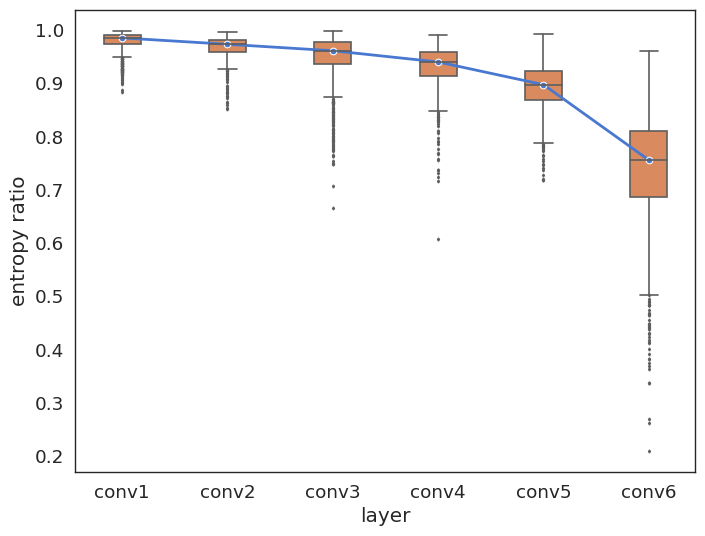

In [91]:
sns.set_theme('paper', style='white', font_scale=1.5, rc={"figure.figsize": (8, 6)})
sns.boxplot(df, x='layer', y='entropy ratio', color=sns.color_palette('muted')[1], width=0.35, fliersize=1.5)
sns.lineplot(df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color=sns.color_palette('muted')[0], marker='o')
# plt.title('Positional entropy ratio of clusters at different layers')
plt.savefig('/scratch/pratyaksh.g/paper-plots/semantic-entropy-vs-layer.pdf')

([<matplotlib.axis.XTick at 0x154350eb81c0>,
 [Text(0, 0, 'conv1'),
  Text(1, 0, 'conv2'),
  Text(2, 0, 'conv3'),
  Text(3, 0, 'conv4'),
  Text(4, 0, 'conv5'),
  Text(5, 0, 'conv6')])

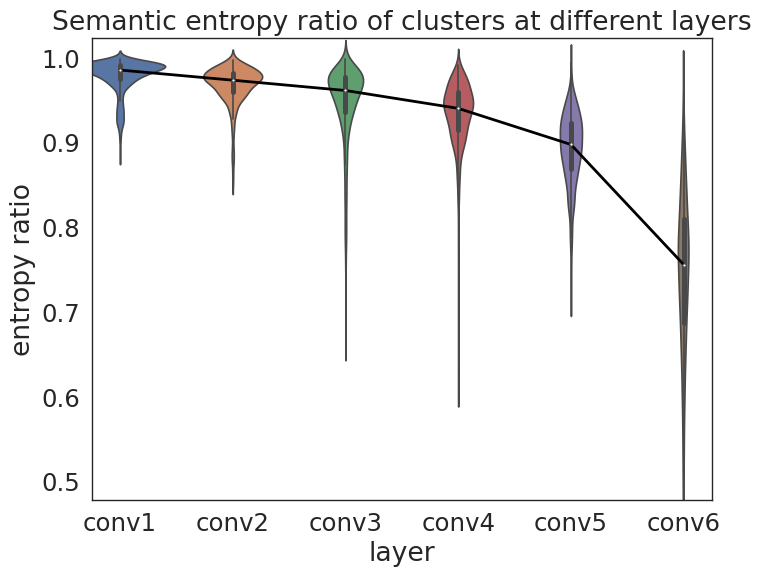

In [90]:
sns.set_theme('paper', style='white', font_scale=2, rc={"figure.figsize": (8, 6)})
sns.violinplot(df, x='layer', y='entropy ratio')
sns.lineplot(df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color='black')
plt.title('Semantic entropy ratio of clusters at different layers')
plt.xticks(ticks=range(6), labels=[f'conv{i}' for i in range(1, 7)])
# plt.savefig('/scratch/pratyaksh.g/paper-plots/semantic-entropy-vs-layer.pdf')

## Cluster-level positional entropy trends

In [12]:
seed_everything(42)

In [13]:
root = '/scratch/pratyaksh.g/'

In [14]:
activation_shapes = pd.read_csv(root + f'{dataset.path_name}/activations/activation_shapes.csv')

In [21]:
channel_entropies = []
max_cn_entropies = []
pos_entropies = []
max_pos_entropies = []
for idx, layer_name in tqdm(enumerate(module_list)):
    clusters = torch.load(root + f'{dataset.path_name}/clusters/{layer_name}.pt')
    n_clusters = torch.load(root + f'{dataset.path_name}/clusters/{layer_name}_n.pt')

    c, w, h = activation_shapes[activation_shapes['layer_name'] == layer_name][['channel', 'width', 'height']].iloc[0]


    pt_idx  = esc_pt[idx]
    clust = rearrange(clusters[:, pt_idx], '(c w h)-> c (w h)', c=c, w=w, h=h)

    ones = torch.ones_like(clust)
    pos_count = scatter(ones.float(), clust.long(), dim=0)
    channel_count = scatter(ones.float(), clust.long(), dim=1)
    ic(channel_count.shape)

    del ones
    del clust

    max_pos_entropy = np.log2(w * h)
    pos_prob = F.normalize(pos_count, p=1, dim=-1, eps=1e-8)
    pos_entropy = - torch.sum(pos_prob * torch.log2(pos_prob + 1e-8), dim=-1)
    if (pos_entropy > max_pos_entropy).any():
        ic(layer_name, pt_idx)
        ic((pos_entropy > max_pos_entropy).nonzero())

    pos_entropies.append(pos_entropy.cpu().numpy())
    max_pos_entropies.append(max_pos_entropy)

    max_cn_entropy = np.log2(c)
    cn_prob = F.normalize(channel_count, p=1, dim=0, eps=1e-8)
    cn_entropy = - torch.sum(cn_prob * torch.log2(cn_prob + 1e-8), dim=0)
    if (cn_entropy > max_cn_entropy).any():
        ic(layer_name, pt_idx)
        ic((cn_entropy > max_cn_entropy).nonzero())

    channel_entropies.append(cn_entropy.cpu().numpy())
    max_cn_entropies.append(max_cn_entropy)

0it [00:00, ?it/s]

ic| channel_count.shape: torch.Size([64, 227])
ic| channel_count.shape: torch.Size([128, 132])
ic| channel_count.shape: torch.Size([256, 267])
ic| channel_count.shape: torch.Size([512, 204])
ic| channel_count.shape: torch.Size([1024, 63])
ic| channel_count.shape: torch.Size([2048, 178])


In [23]:
channel_entropies[0]

array([ 4.73448   ,  3.9489183 ,  4.8887844 ,  4.322086  ,  4.4138165 ,
        5.637738  ,  4.3803945 ,  4.655279  ,  4.3009367 ,  4.3998322 ,
        4.4245043 ,  4.966523  ,  4.221005  ,  4.292476  ,  3.6656752 ,
        4.4266887 ,  4.3909554 ,  4.2029037 ,  5.0284667 ,  4.320485  ,
        4.1406784 ,  4.1883793 ,  0.95647186,  4.208323  ,  4.2324476 ,
        2.0644763 ,  4.258524  ,  4.118899  ,  4.99747   ,  4.789865  ,
        4.3557234 ,  4.3193274 ,  4.223777  ,  5.4935093 ,  4.9640274 ,
        3.8919349 ,  0.69340664,  5.0820985 ,  3.8598237 ,  4.8550797 ,
        4.2119055 ,  4.1726303 ,  4.043905  ,  4.0768805 ,  4.9533606 ,
        4.4139743 ,  4.0456076 ,  4.0398827 ,  4.9862075 ,  4.9425316 ,
        1.5503691 ,  4.137122  ,  4.067375  ,  4.8497133 ,  3.8851802 ,
        3.936417  ,  4.1715803 ,  4.10658   ,  3.9999933 ,  5.0109763 ,
        4.8038874 ,  3.2265525 ,  4.1095433 ,  4.7788863 ,  4.0160074 ,
        4.9965925 ,  3.96588   ,  4.0973616 ,  4.8596244 ,  4.91

In [24]:
pos_df = pd.DataFrame({
    'layer': sum([[f'conv{i + 1}'] * len(x) for i, x in enumerate(pos_entropies)], start=[]),
    'entropy': np.concatenate(pos_entropies),
    'max entropy': sum([[mx] * len(x) for mx, x in zip(max_pos_entropies, pos_entropies)], start=[]),
})
pos_df['entropy ratio'] = pos_df['entropy'] / pos_df['max entropy']

In [25]:
cn_df = pd.DataFrame({
    'layer': sum([[f'conv{i + 1}'] * len(x) for i, x in enumerate(channel_entropies)], start=[]),
    'entropy': np.concatenate(channel_entropies),
    'max entropy': sum([[mx] * len(x) for mx, x in zip(max_cn_entropies, channel_entropies)], start=[]),
})
cn_df['entropy ratio'] = cn_df['entropy'] / cn_df['max entropy']

In [70]:
pos_df.to_csv('/scratch/pratyaksh.g/paper-plots/positional-entropy-vs-layer.csv')
cn_df.to_csv('/scratch/pratyaksh.g/paper-plots/channel-entropy-vs-layer.csv')

In [71]:
df = pd.read_csv('/scratch/pratyaksh.g/paper-plots/channel-entropy-vs-layer.csv')

In [80]:
cn_df

,layer,entropy,max entropy,entropy ratio
0,conv1,4.734480,6.0,0.789080
1,conv1,3.948918,6.0,0.658153
2,conv1,4.888784,6.0,0.814797
3,conv1,4.322086,6.0,0.720348
4,conv1,4.413816,6.0,0.735636
...,...,...,...,...
1066,conv6,1.000000,11.0,0.090909
1067,conv6,1.000000,11.0,0.090909
1068,conv6,0.999571,11.0,0.090870
1069,conv6,0.999610,11.0,0.090874


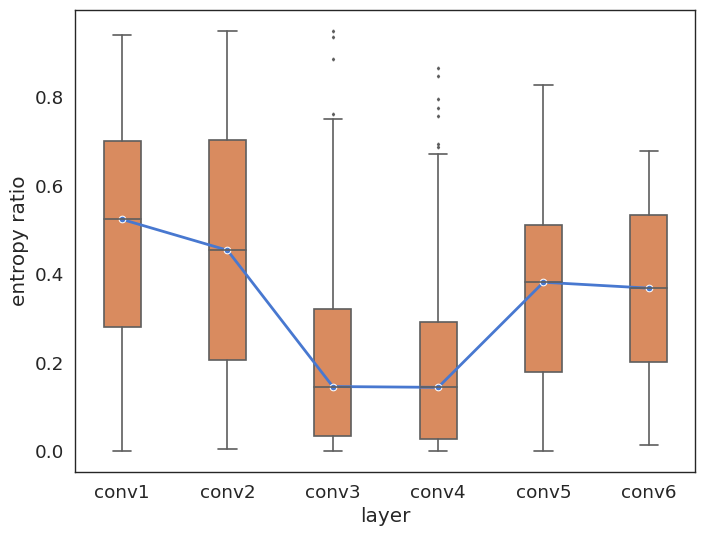

In [81]:
sns.set_theme('paper', style='white', font_scale=1.5, rc={"figure.figsize": (8, 6)})
sns.boxplot(df, x='layer', y='entropy ratio', color=sns.color_palette('muted')[1], width=0.35, fliersize=1.5)
sns.lineplot(df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color=sns.color_palette('muted')[0], marker='o')
# plt.title('Positional entropy ratio of clusters at different layers')
plt.savefig('/scratch/pratyaksh.g/paper-plots/channel-entropy-vs-layer.pdf')

<AxesSubplot:xlabel='layer', ylabel='entropy'>

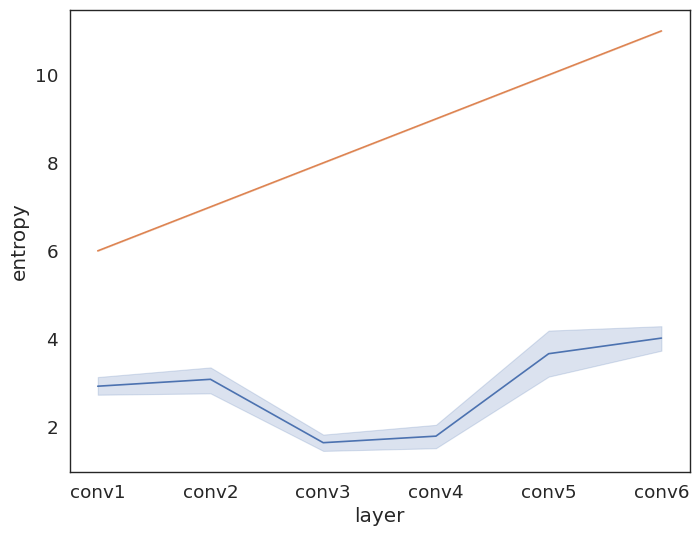

In [84]:
sns.lineplot(df, x='layer', y='entropy', legend=True)
sns.lineplot(df, x='layer', y='max entropy', legend=True)

## Combined

In [8]:
pos_df = pd.read_csv('/scratch/pratyaksh.g/paper-plots/positional-entropy-vs-layer.csv')
cn_df = pd.read_csv('/scratch/pratyaksh.g/paper-plots/channel-entropy-vs-layer.csv')
sem_df = pd.read_csv('/scratch/pratyaksh.g/paper-plots/semantic-entropy-vs-layer.csv')

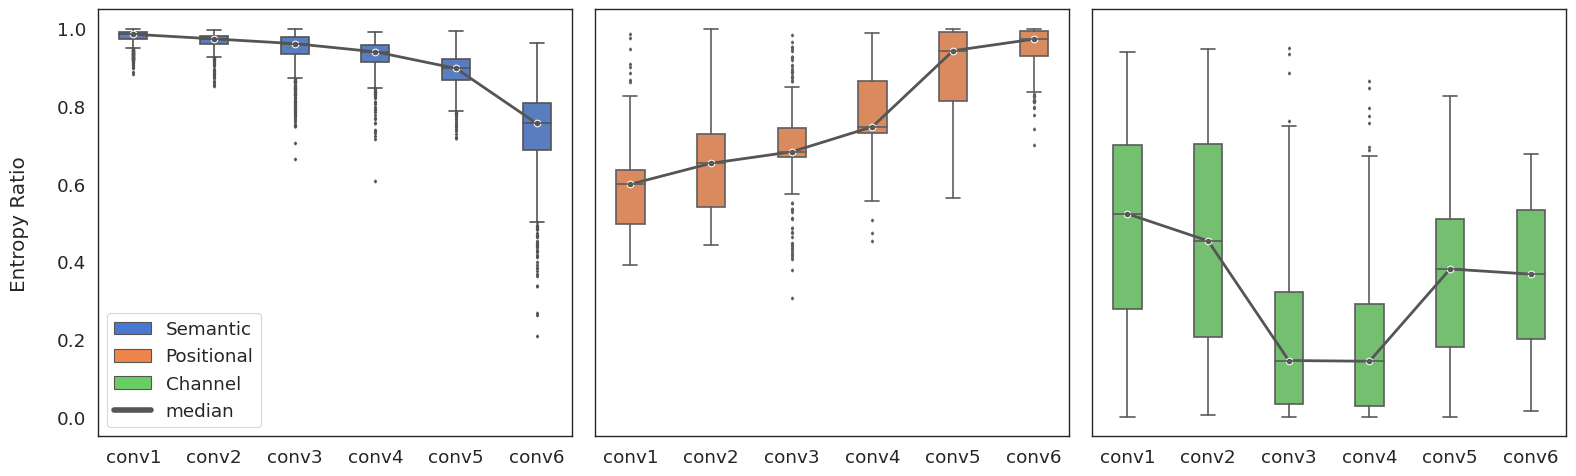

In [9]:
sns.set_theme('paper', style='white', font_scale=1.5)

handles = []
plt.subplots(1, 3, figsize=(16, 5), sharey=True)

pal = sns.color_palette('muted')

plt.subplot(1, 3, 1)
sns.boxplot(sem_df, x='layer', y='entropy ratio', color=pal[0], width=0.35, fliersize=1.5)
sns.lineplot(sem_df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color='#555', marker='o')
plt.ylabel('Entropy Ratio', labelpad=20)
plt.xlabel('')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=pal[0], edgecolor='#555', label='Semantic'),
    Patch(facecolor=pal[1], edgecolor='#555', label='Positional'),
    Patch(facecolor=pal[2], edgecolor='#555', label='Channel'),
    Line2D([0], [0], color='#555', lw=4, label='median'),
]
plt.gca().legend(handles=legend_elements)#, prop={'size': 6})

plt.subplot(1, 3, 2)
sns.boxplot(pos_df, x='layer', y='entropy ratio', color=pal[1], width=0.35, fliersize=1.5)
sns.lineplot(pos_df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color='#555', marker='o')
plt.ylabel('')
plt.xlabel('')

plt.subplot(1, 3, 3)
sns.boxplot(cn_df, x='layer', y='entropy ratio', color=pal[2], width=0.35, fliersize=1.5)
sns.lineplot(cn_df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color='#555', marker='o')
plt.ylabel('')
plt.xlabel('')

plt.tight_layout()
plt.savefig('/scratch/pratyaksh.g/paper-plots/entropy-vs-layer.pdf')

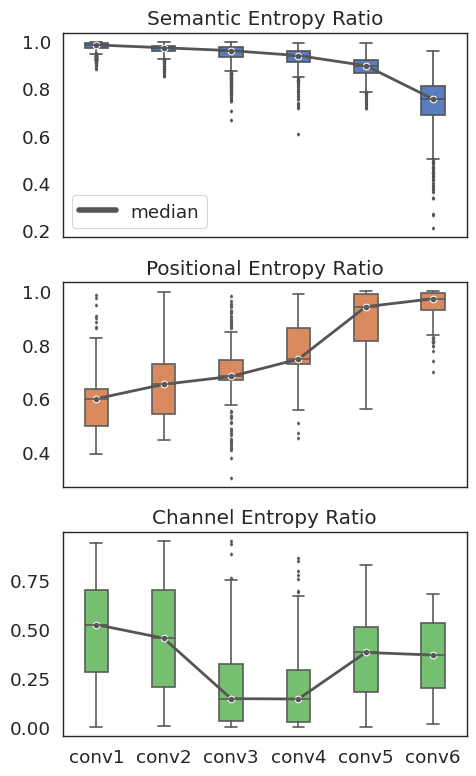

In [20]:
sns.set_theme('paper', style='white', font_scale=1.5)

handles = []
plt.subplots(3, 1, figsize=(5, 8), sharex=True)

pal = sns.color_palette('muted')

plt.subplot(3, 1, 1)
sns.boxplot(sem_df, x='layer', y='entropy ratio', color=pal[0], width=0.35, fliersize=1.5)
sns.lineplot(sem_df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color='#555', marker='o')
# plt.ylabel('Entropy Ratio', labelpad=20)
plt.ylabel('')
plt.xlabel('')
plt.title('Semantic Entropy Ratio')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    # Patch(facecolor=pal[0], edgecolor='#555', label='Semantic'),
    # Patch(facecolor=pal[1], edgecolor='#555', label='Positional'),
    # Patch(facecolor=pal[2], edgecolor='#555', label='Channel'),
    Line2D([0], [0], color='#555', lw=4, label='median'),
]
plt.gca().legend(handles=legend_elements)#, prop={'size': 6})

plt.subplot(3, 1, 2)
sns.boxplot(pos_df, x='layer', y='entropy ratio', color=pal[1], width=0.35, fliersize=1.5)
sns.lineplot(pos_df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color='#555', marker='o')
plt.ylabel('')
plt.xlabel('')
plt.title('Positional Entropy Ratio')

plt.subplot(3, 1, 3)
sns.boxplot(cn_df, x='layer', y='entropy ratio', color=pal[2], width=0.35, fliersize=1.5)
sns.lineplot(cn_df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color='#555', marker='o')
plt.ylabel('')
plt.xlabel('')
plt.title('Channel Entropy Ratio')

plt.tight_layout()
plt.savefig('/scratch/pratyaksh.g/paper-plots/entropy-vs-layer.pdf')

In [10]:
sns.set_theme('paper', style='white', font_scale=1.5, rc={"figure.figsize": (8, 6)})
sns.boxplot(df, x='layer', y='entropy ratio', color=sns.color_palette('muted')[1], width=0.35, fliersize=1.5)
sns.lineplot(df.groupby('layer').median() , x='layer', y='entropy ratio', linewidth=2, color=sns.color_palette('muted')[0], marker='o')
# plt.title('Positional entropy ratio of clusters at different layers')
plt.savefig('/scratch/pratyaksh.g/paper-plots/channel-entropy-vs-layer.pdf')

NameError: name 'df' is not defined